In [1]:
# The Base libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import laspy

# The Deep Learning libraries
import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

In [2]:
#check if cuda is avaualble and check gpu number
print('CUDA available -> ', torch.cuda.is_available())
print('CUDA GPU number -> ', torch.cuda.device_count())
print('GPU -> ', torch.cuda.get_device_name())

CUDA available ->  True
CUDA GPU number ->  1
GPU ->  NVIDIA GeForce GTX 1650


In [3]:
#selecting model checkpoint
MODEL = "sam_vit_l_0b3195.pth"
#selecting gpu with cuda
USED_D = torch.device('cuda:0')

In [4]:
sam = sam_model_registry["vit_l"](checkpoint = MODEL)

#Cast your model to a specific device (cuda or cpu)
sam.to(device = USED_D)

C:\Users\ROG\anaconda3\envs\GEOSAM\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:
#When loading an image with openCV, it is in bgr by default
loaded_img = cv2.imread("frontfaceimg.png")

#Now we get the R,G,B image
image_rgb = cv2.cvtColor(loaded_img, cv2.COLOR_BGR2RGB)

In [6]:
mask_generator = SamAutomaticMaskGenerator(sam)
result = mask_generator.generate(image_rgb)

In [7]:
def sam_masks(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))
        c_mask.append(img)
    return c_mask

In [8]:
print('Mem allocated by other programs: ', torch.cuda.memory_allocated(), 'reserved:', torch.cuda.memory_reserved())
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
gc.collect()
torch.cuda.empty_cache()

#If the GPU memory is not freed enough, try rebooting your (Windows) computer.
#ALSO, try using the following line if memory problems persist
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

Mem allocated by other programs:  1258960384 reserved: 5052039168


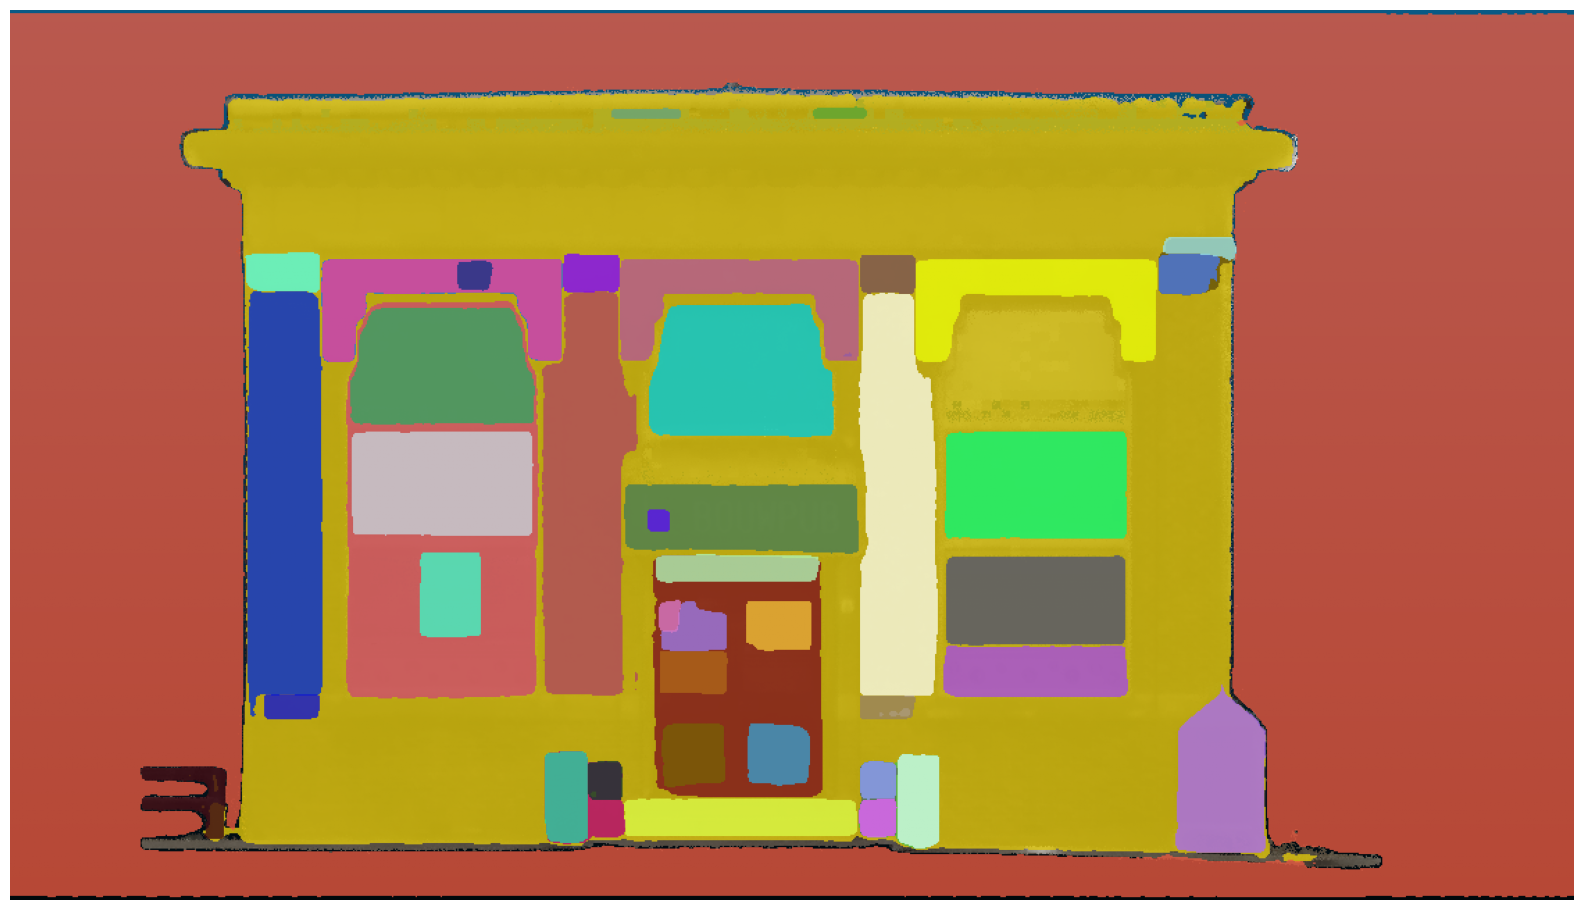

In [9]:
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("test_result.jpg")

In [10]:
def cloud_to_image(pcd_np, resolution):
    minx = np.min(pcd_np[:, 0])
    maxx = np.max(pcd_np[:, 0])
    miny = np.min(pcd_np[:, 1])
    maxy = np.max(pcd_np[:, 1])

    width = int((maxx - minx) / resolution) + 1
    height = int((maxy - miny) / resolution) + 1

    # Initialize empty image
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Compute pixel coordinates
    pixel_x = np.clip(((pcd_np[:, 0] - minx) / resolution).astype(int), 0, width - 1)
    pixel_y = np.clip(((maxy - pcd_np[:, 1]) / resolution).astype(int), 0, height - 1)

    # Assign color to the image
    image[pixel_y, pixel_x] = pcd_np[:, -3:].astype(np.uint8)

    return image

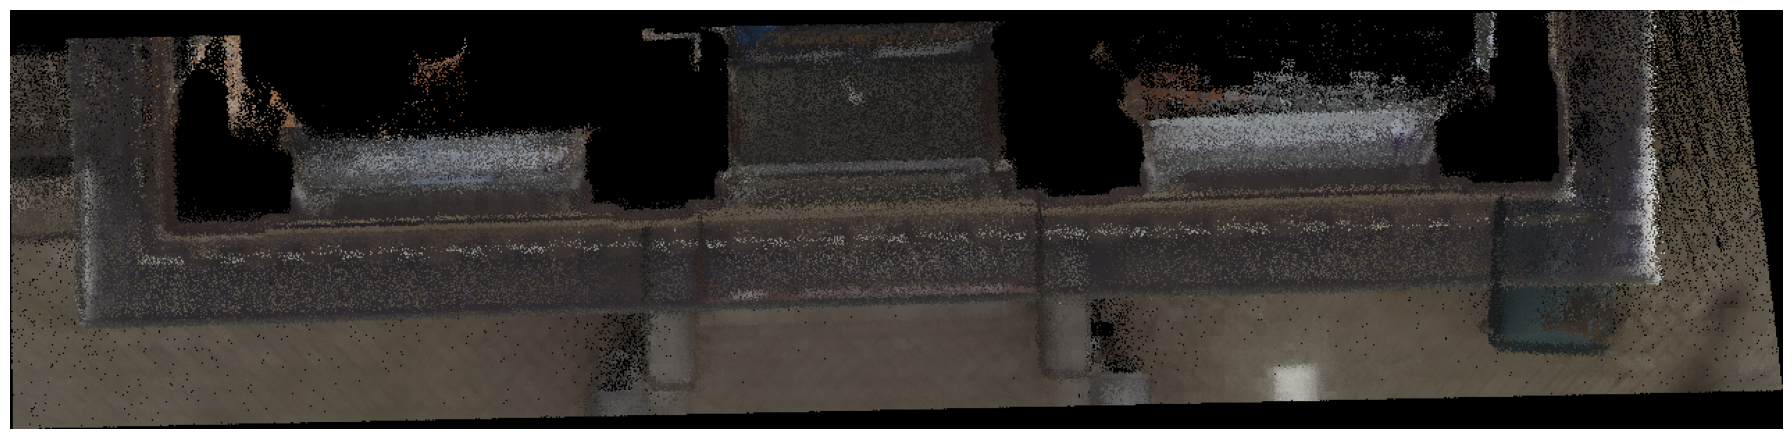

In [11]:
#Reading the point cloud with laspy
pcd = laspy.read("buowpub_front_face - Cloud.las")

#Transforming the point cloud to Numpy
pcd_np = np.vstack((pcd.x, pcd.y, pcd.z, (pcd.red/65535*255).astype(int), (pcd.green/65535*255).astype(int), (pcd.blue/65535*255).astype(int))).transpose()

#Ortho-Projection
orthoimage = cloud_to_image(pcd_np, 0.01)

#Plotting and exporting
fig = plt.figure(figsize=(np.shape(orthoimage)[1]/72, np.shape(orthoimage)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(orthoimage)
plt.axis('off')
plt.savefig("orthoimage_test.jpg")

In [12]:
print(np.shape(orthoimage))


(302, 1276, 3)


In [13]:
def generate_spherical_image(center_coordinates, point_cloud, colors, resolution_y=500):
    # Translate the point cloud by the negation of the center coordinates
    translated_points = point_cloud - center_coordinates

    # Convert 3D point cloud to spherical coordinates
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
    phi = np.arccos(translated_points[:, 2] / np.linalg.norm(translated_points, axis=1))

    # Map spherical coordinates to pixel coordinates
    x = (theta + np.pi) / (2 * np.pi) * (2 * resolution_y)
    y = phi / np.pi * resolution_y

     # Create the spherical image with RGB channels
    resolution_x = 2 * resolution_y
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)

    # Create the mapping between point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)

    # Assign points to the image pixels
    for i in range(len(translated_points)):
        ix = np.clip(int(x[i]), 0, resolution_x - 1)
        iy = np.clip(int(y[i]), 0, resolution_y - 1)
        if mapping[iy, ix] == -1 or np.linalg.norm(translated_points[i]) < np.linalg.norm(translated_points[mapping[iy, ix]]):
            mapping[iy, ix] = i
            image[iy, ix] = colors[i]
    return image, mapping

In [14]:
#Loading the las file from the disk
las = laspy.read("buowpub_front_face - Cloud.las")

#Transforming to a numpy array
coords = np.vstack((las.x, las.y, las.z))
point_cloud = coords.transpose()

#Gathering the colors
r=(las.red/65535*255).astype(int)
g=(las.green/65535*255).astype(int)
b=(las.blue/65535*255).astype(int)
colors = np.vstack((r,g,b)).transpose()

In [15]:
resolution = 1000

#Defining the position in the point cloud to generate a panorama
center_coordinates = [6, 4, 3]

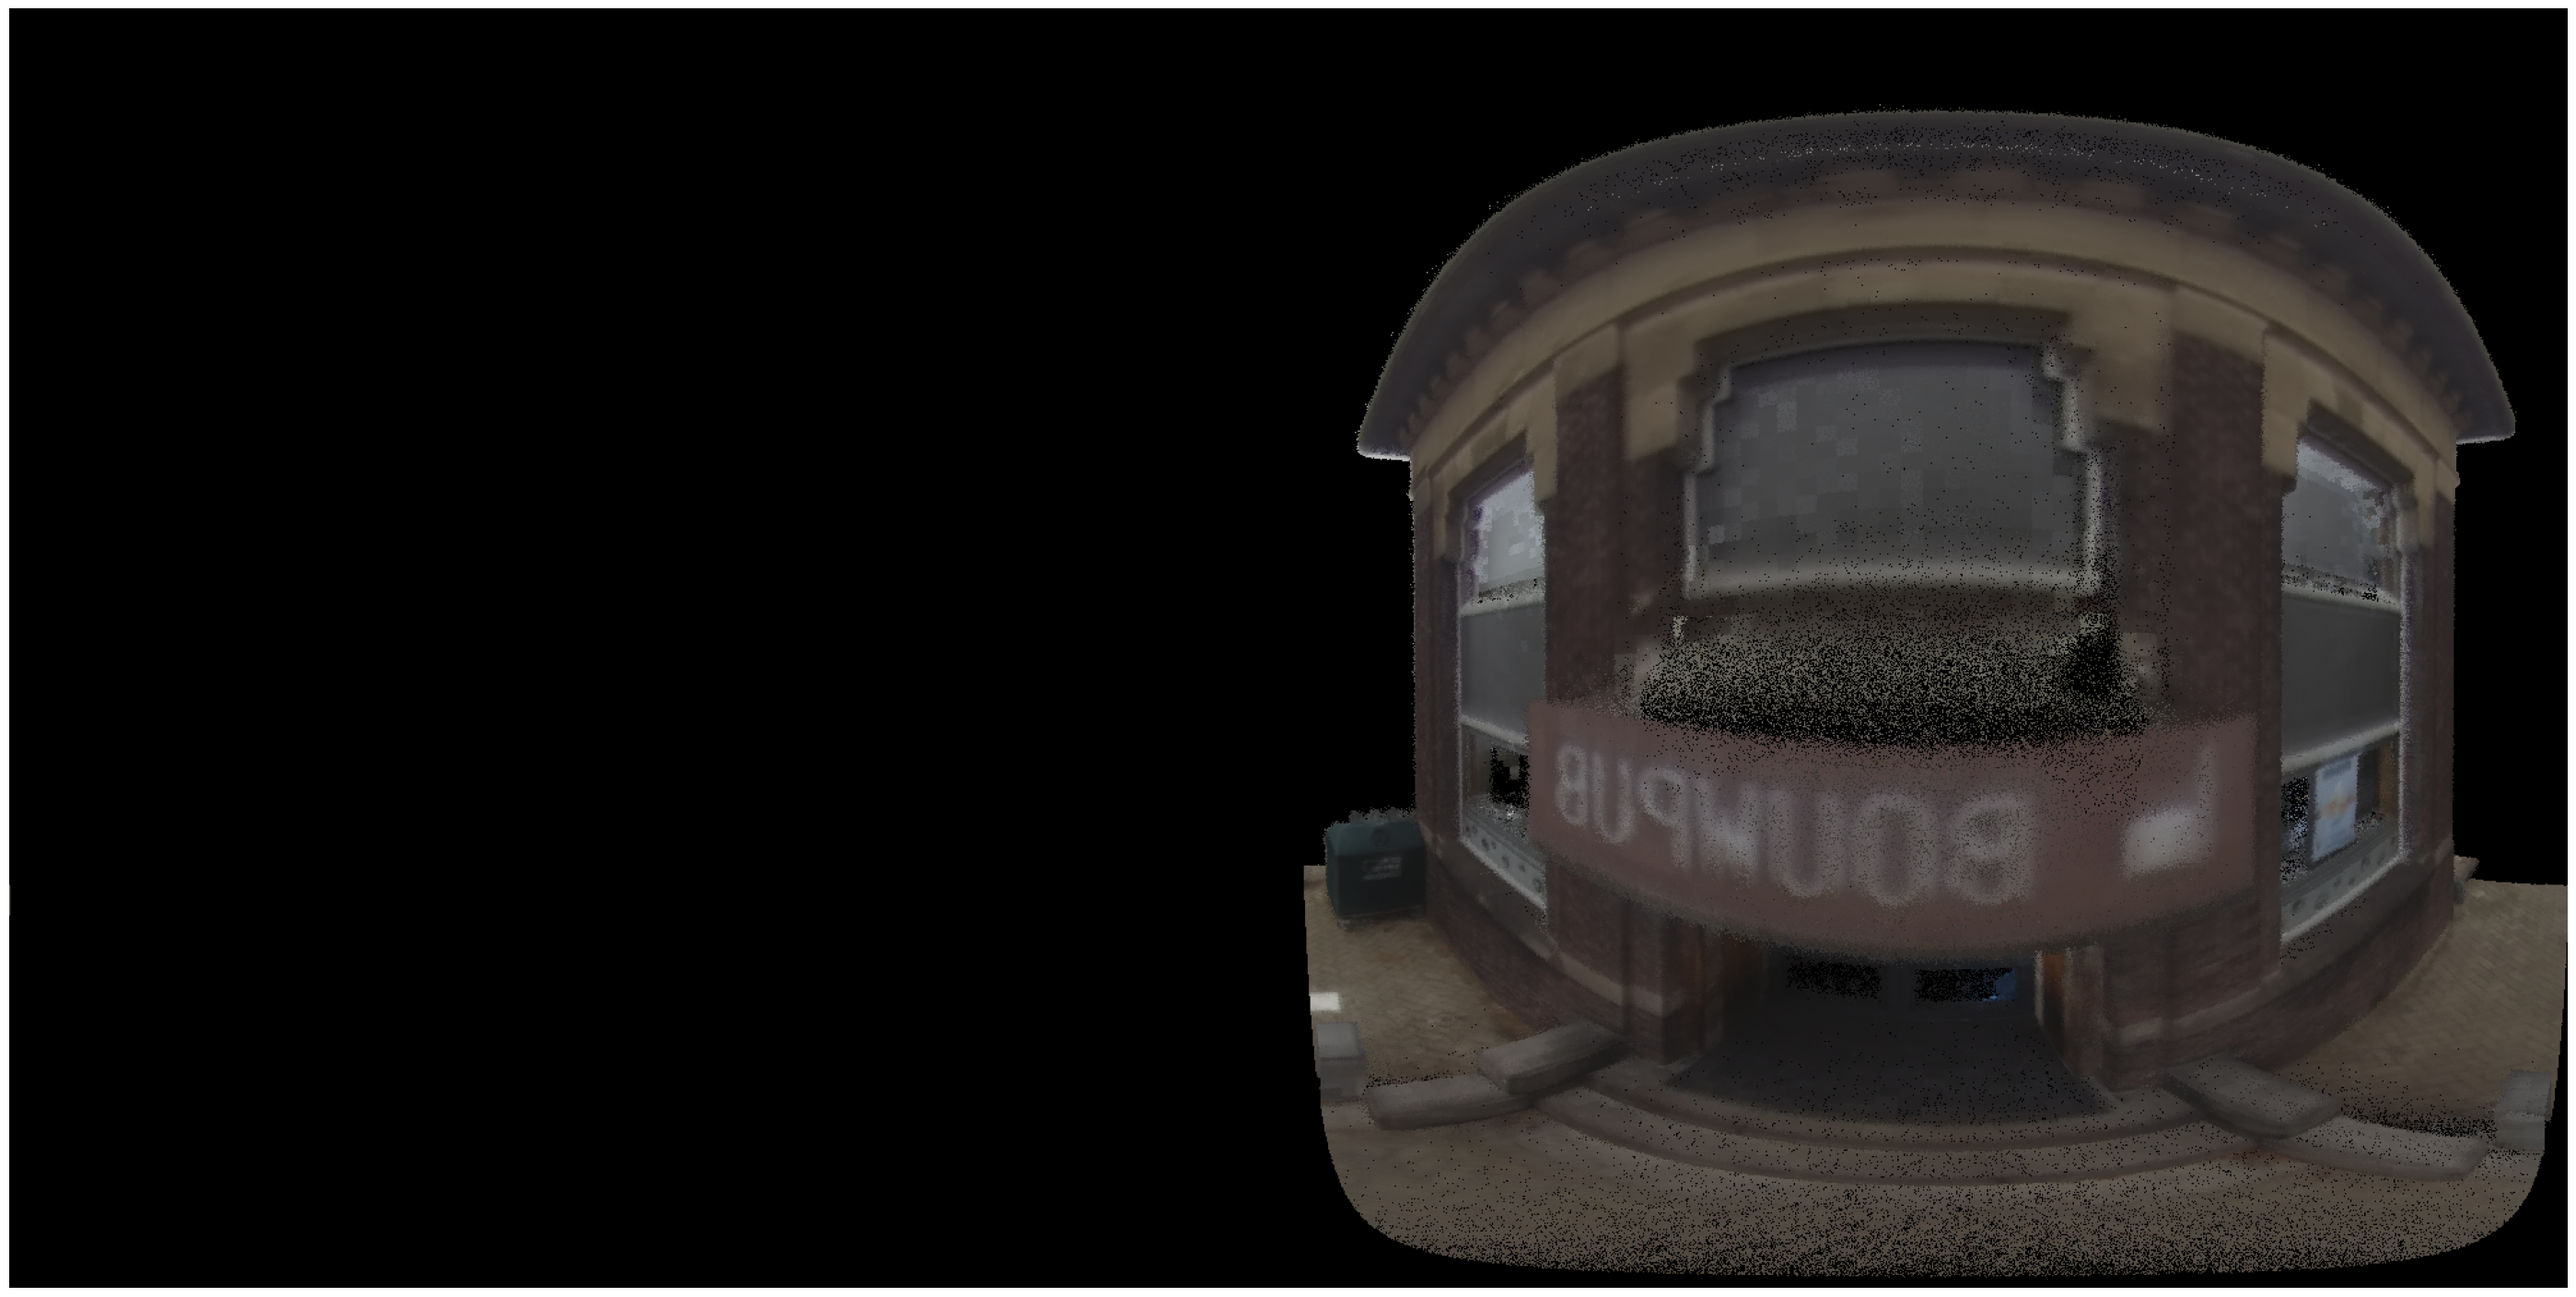

In [16]:
#Function Execution
spherical_image, mapping = generate_spherical_image(center_coordinates, point_cloud, colors, resolution)

#Plotting with matplotlib
fig = plt.figure(figsize=(np.shape(spherical_image)[1]/72, np.shape(spherical_image)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(spherical_image)
plt.axis('off')

#Saving to the disk
plt.savefig("BUILDING_spherical_projection.jpg")

In [17]:
sam = sam_model_registry["vit_l"](checkpoint = MODEL)
sam.to(device = USED_D)

mask_generator = SamAutomaticMaskGenerator(sam)

temp_img = cv2.imread("BUILDING_spherical_projection.jpg")
image_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

result = mask_generator.generate(image_rgb)


C:\Users\ROG\anaconda3\envs\GEOSAM\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


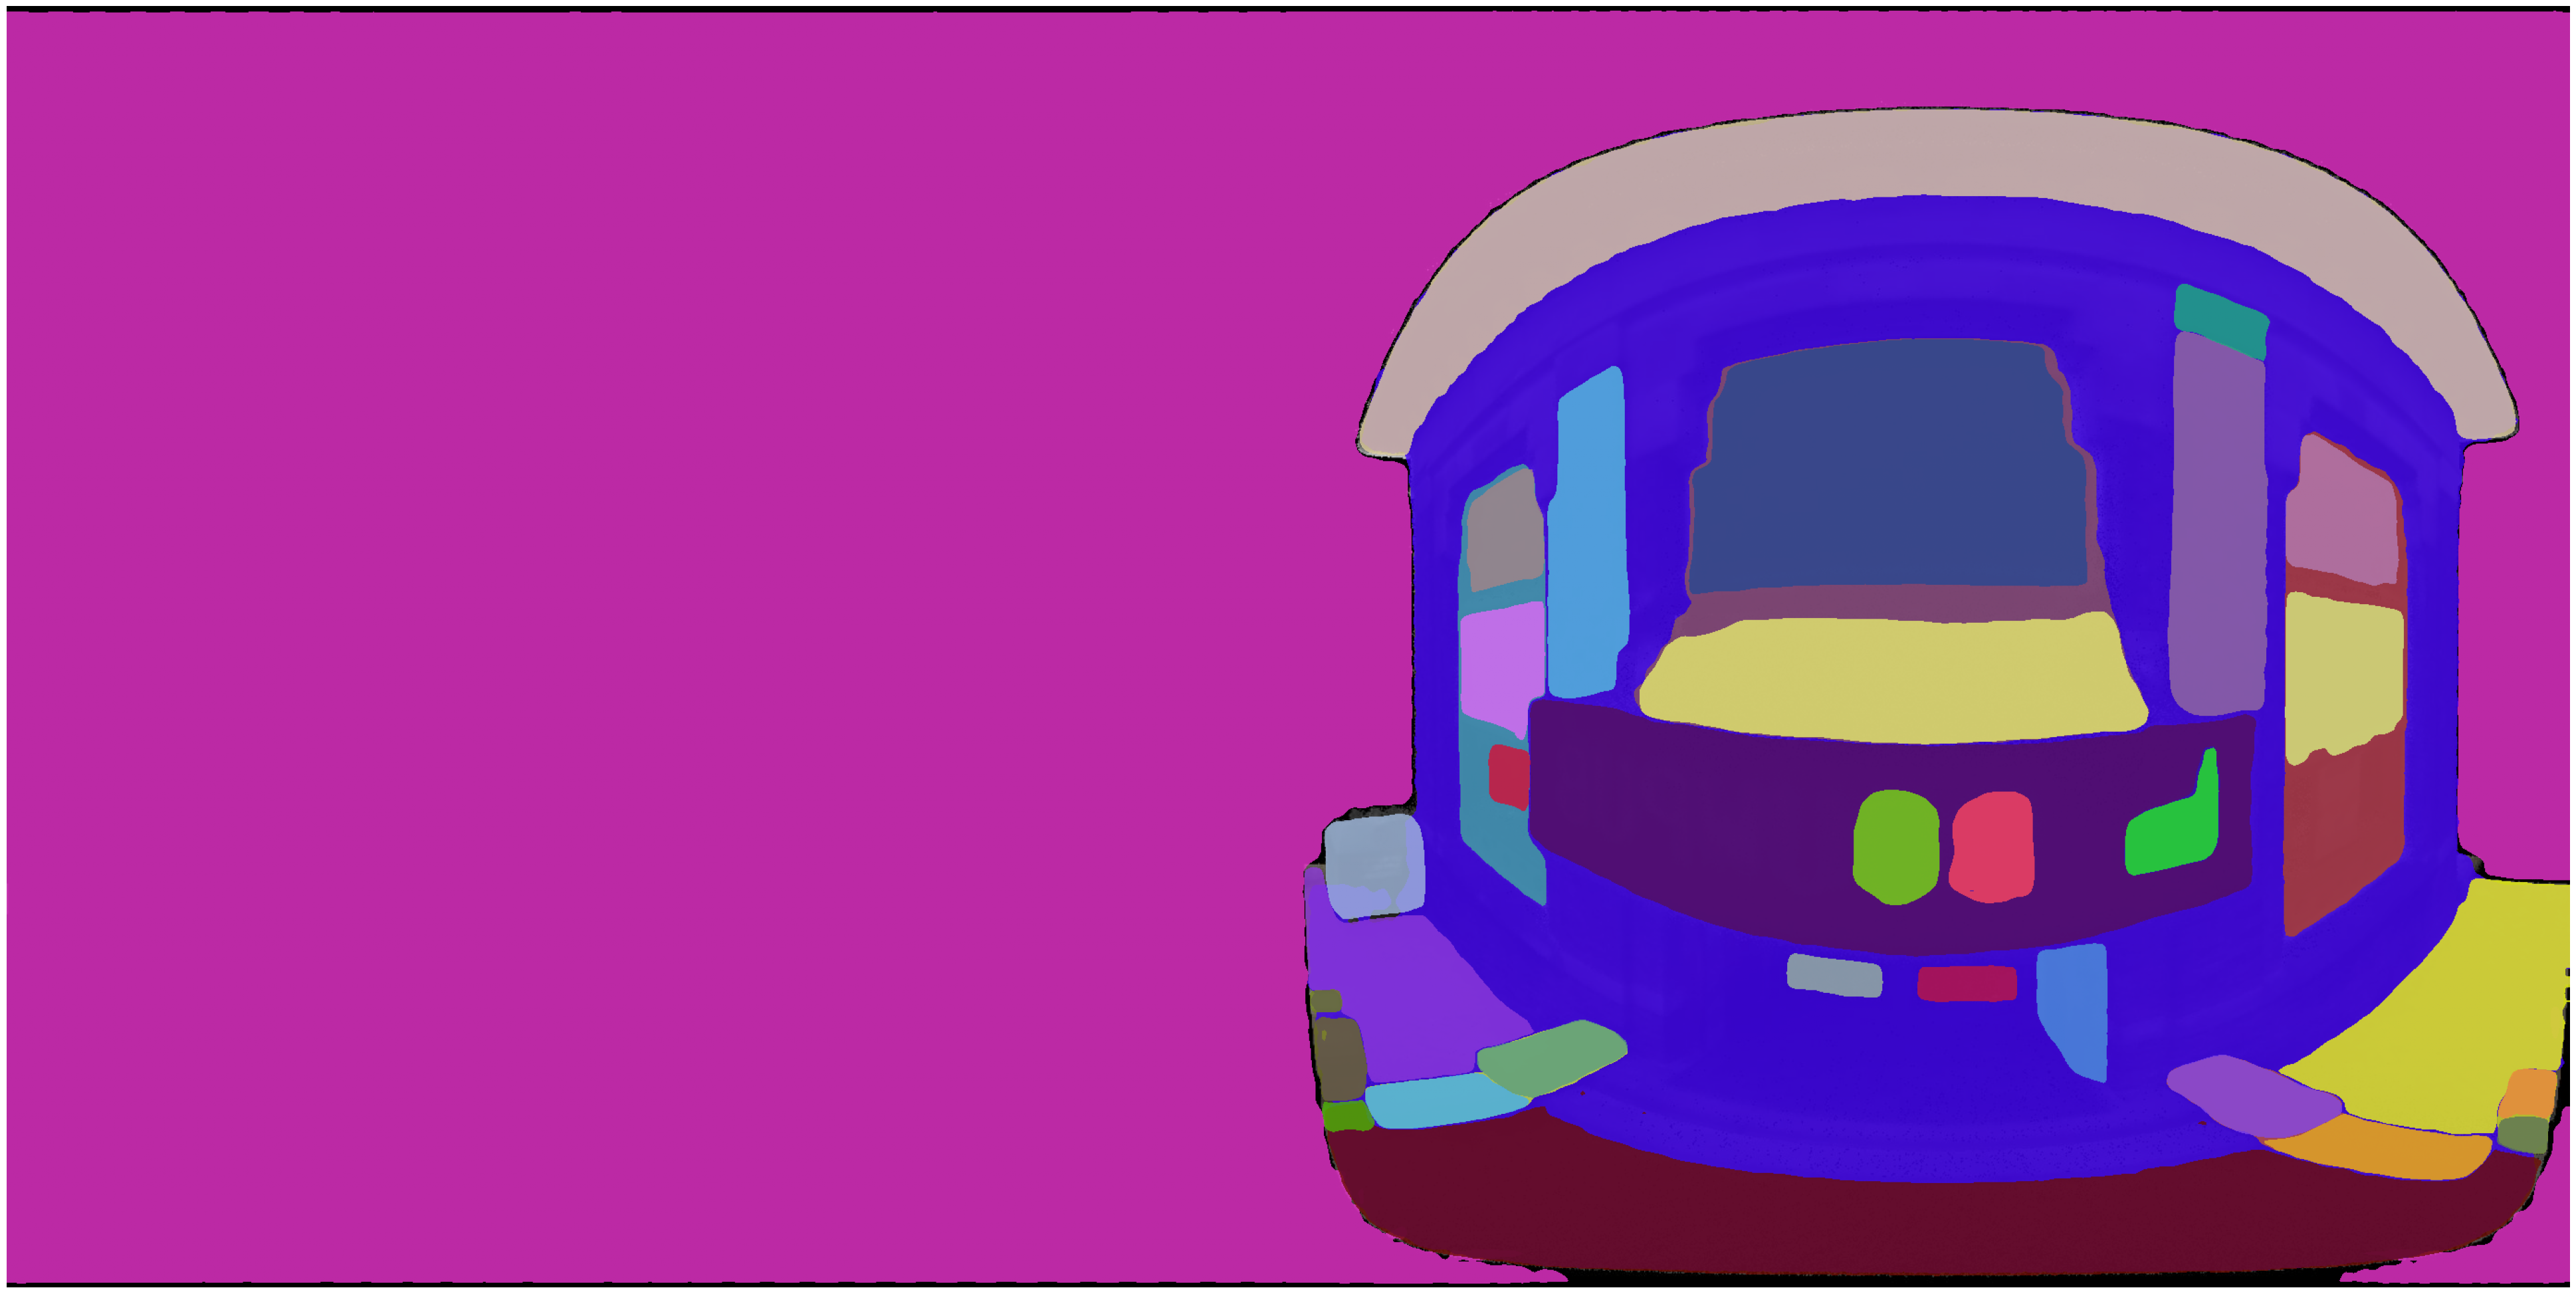

In [18]:
#Plotting it back to img
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("BUILDING_spherical_projection_segmented.jpg")

In [19]:

image_path = "BUILDING_spherical_projection_segmented.jpg"
def color_point_cloud(image_path, point_cloud, mapping):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # Create an empty array to store the modified point cloud
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1] + 3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud  # Copy the original point cloud

    for iy in range(h):
        for ix in range(w):
            # Clip ix and iy to ensure they don't exceed the bounds
            ix_clipped = np.clip(ix, 0, mapping.shape[1] - 1)
            iy_clipped = np.clip(iy, 0, mapping.shape[0] - 1)

            point_index = mapping[iy_clipped, ix_clipped]

            if point_index != -1:  # Ensure the point is valid
                color = image[iy_clipped, ix_clipped]
                modified_point_cloud[point_index, 3:] = color  # Assign color to the point cloud
                print(f"Assigned color {color} to point index {point_index}")

    return modified_point_cloud

In [ ]:
modified_point_cloud = color_point_cloud(image_path, point_cloud, mapping)

In [ ]:
def export_point_cloud(cloud_path, modified_point_cloud):
    # 1. Create a new header
    header = laspy.LasHeader(point_format=3, version="1.2")
    header.add_extra_dim(laspy.ExtraBytesParams(name="random", type=np.int32))

    # 2. Create a Las
    las_o = laspy.LasData(header)
    las_o.x = modified_point_cloud[:,0]
    las_o.y = modified_point_cloud[:,1]
    las_o.z = modified_point_cloud[:,2]
    las_o.red = (modified_point_cloud[:, 3] * 256).astype(np.uint16)
    las_o.green = (modified_point_cloud[:, 4] * 256).astype(np.uint16)
    las_o.blue = (modified_point_cloud[:, 5] * 256).astype(np.uint16)
    las_o.write(cloud_path)
    
    print("Export succesful at: ", cloud_path)
    return

In [ ]:
export_point_cloud("pcd_results.las", modified_point_cloud)